In [352]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import nltk
import random

### Reading the CSV files

In [209]:
train = pd.read_csv(r"C:\Users\user\Documents\Securly Assignment\dataset\dataset\train.csv\train.csv")
test = pd.read_csv(r"C:\Users\user\Documents\Securly Assignment\dataset\dataset\test.csv\test.csv")

In [210]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [347]:
test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all


In [414]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [415]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### This is a multi label, multi classification problem that can be solved using LSTM's

Data Pre-Processing steps:

* Cleaning the text
* Tokenizing
* TextToSequence
* Padding 

In [212]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [213]:
train['comment_text'] = train['comment_text'].apply(clean_text)

In [348]:
test['comment_text'] = test['comment_text'].apply(clean_text)

In [381]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input

In [215]:
train_data = train['comment_text']
train_labels = train.drop(['id','comment_text'], axis=1)

In [216]:
train_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [366]:
cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[cols].values

train_df = train['comment_text']
test_df = test['comment_text']

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


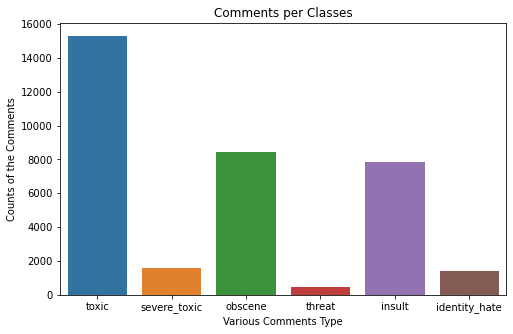

In [369]:
val_counts = train[cols].sum()
print(val_counts)
plt.figure(figsize=(8,5))
ax = sns.barplot(val_counts.index, val_counts.values)

plt.title("Comments per Classes")
plt.xlabel("Various Comments Type")
plt.ylabel("Counts of the Comments")
plt.show()

In [218]:
test['comment_text'] = test['comment_text'].apply(clean_text)

In [219]:
test_data = test['comment_text']

In [220]:
#prepare tokenizer
tokenizer = Tokenizer(num_words = 30000) 
tokenizer.fit_on_texts(train_data)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(train_data)
test_final = tokenizer.texts_to_sequences(test_data)

In [223]:
train_data=pad_sequences(train_final, maxlen=200)
test_data=pad_sequences(test_final, maxlen=200)

In [224]:
train_data.shape

(159571, 200)

In [225]:
type(test_data)

numpy.ndarray

In [226]:
test_data.shape

(153164, 200)

In [227]:
train_data

array([[    0,     0,     0, ...,  4524,  2241,   961],
       [    0,     0,     0, ...,   570,  8186,   177],
       [    0,     0,     0, ...,     1,   721,   455],
       ...,
       [    0,     0,     0, ...,  3464, 13106,  4366],
       [    0,     0,     0, ...,   147,    34,    11],
       [    0,     0,     0, ...,  1599,  2034,    86]])

In [228]:
train_labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [229]:
from sklearn.model_selection import train_test_split

In [398]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.33, random_state=42)

In [399]:
X_train.shape

(106912, 200)

In [400]:
y_train.shape

(106912, 6)

In [401]:
X_test.shape

(52659, 200)

In [402]:
y_test.shape

(52659, 6)

In [403]:
model = Sequential()
model.add(Embedding(30000, 128))
model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(units = 6, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         3840000   
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 4,103,942
Trainable params: 4,103,942
Non-trainable params: 0
_________________________________________________________________


In [404]:
from sklearn.metrics import f1_score, classification_report
#tf.keras.metrics.Precision(), tf.keras.metrics.Recall()

In [405]:
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.fit(X_train, y_train, batch_size = 128, epochs = 1, validation_data = (X_test, y_test))

836/836 [==============================] - 1019s 1s/step - loss: 0.2245 - auc: 0.8467 - precision_1: 0.5328 - recall_1: 0.0374 - val_loss: 0.2224 - val_auc: 0.8713 - val_precision_1: 0.4399 - val_recall_1: 0.0678


In [410]:
model2 = Sequential()
model2.add(Embedding(30000, 128))
model2.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout=0.2, return_sequences=True))
model2.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2))
model2.add(Dense(units = 6, activation = 'sigmoid'))
model2.summary()

model2.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model2.fit(X_train, y_train, batch_size = 128, epochs = 1, validation_data = (X_test, y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         3840000   
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 4,103,942
Trainable params: 4,103,942
Non-trainable params: 0
_________________________________________________________________
836/836 [==============================] - 1001s 1s/step - loss: 0.0978 - auc: 0.9090 - precision_2: 0.7336 - recall_2: 0.3610 - val_loss: 0.0550 - val_auc: 0.9789 - val_precision_2: 0.7738 - val_recall_2: 0.6437


In [406]:
samp_sub = pd.read_csv(r"C:\Users\user\Documents\Securly Assignment\dataset\dataset\result.csv")

In [411]:
metric1 = model.evaluate(X_test, y_test, verbose=0, return_dict=True)
print(metric1)

{'loss': 0.22241778671741486, 'auc': 0.8713079690933228, 'precision_1': 0.43988919258117676, 'recall_1': 0.0678284615278244}


In [412]:
metric2 = model2.evaluate(X_test, y_test, verbose=0, return_dict=True)
print(metric2)

{'loss': 0.05503806099295616, 'auc': 0.9788596034049988, 'precision_2': 0.7737728357315063, 'recall_2': 0.6436870098114014}


In [416]:
p = metric1['precision_1']
r = metric1['recall_1']
f1 = 2*(p * r)/ (p + r)
print('f1 score with softmax activation function is', f1)

f1 score with softmax activation function is 0.11753385738717063


In [417]:
p = metric2['precision_2']
r = metric2['recall_2']
f1 = 2*(p * r)/ (p + r)
print('f1 score with sigmoid activation function is', f1)

f1 score with sigmoid activation function is 0.7027606806237744


* Sigmoid Activation function performs better

In [248]:
model.predict(test_data[0])

array([[0.46303588, 0.4663035 , 0.46001282, 0.4711761 , 0.46045652,
        0.47640643],
       [0.46303588, 0.4663035 , 0.46001282, 0.4711761 , 0.46045652,
        0.47640643],
       [0.46303588, 0.4663035 , 0.46001282, 0.4711761 , 0.46045652,
        0.47640643],
       ...,
       [0.5117209 , 0.48810843, 0.50576156, 0.47848567, 0.4989303 ,
        0.48650268],
       [0.44902712, 0.4601724 , 0.44605568, 0.46621406, 0.45203292,
        0.4683992 ],
       [0.45184758, 0.46225062, 0.44887638, 0.46960244, 0.4531994 ,
        0.47117957]], dtype=float32)

In [419]:
preds = model2.predict(test_data)

In [420]:
samp_sub[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = preds

In [421]:
samp_sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.886920,0.184733,0.782119,0.056756,0.604735,0.156699
1,0000247867823ef7,0.005843,0.000354,0.001012,0.000527,0.001350,0.000814
2,00013b17ad220c46,0.017338,0.000567,0.002544,0.000928,0.003528,0.001546
3,00017563c3f7919a,0.007386,0.000410,0.001195,0.000626,0.001681,0.000944
4,00017695ad8997eb,0.013474,0.000520,0.002006,0.000838,0.002860,0.001324


In [265]:
samp_sub.columns

Index(['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [422]:
list_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']

In [423]:
def impute_labels(df): # function to impute labels as 0 and 1
    for i in range(len(df)):
        for column in list_columns:
            if df[column][i] > 0.75:
                df[column][i] = 1.0
            else:
                df[column][i] = 0.0                
    return df

In [424]:
impute_labels(samp_sub)

<ipython-input-423-c833d287eab2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = 1.0
<ipython-input-423-c833d287eab2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = 0.0


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.0,0.0,1.0,0.0,0.0,0.0
1,0000247867823ef7,0.0,0.0,0.0,0.0,0.0,0.0
2,00013b17ad220c46,0.0,0.0,0.0,0.0,0.0,0.0
3,00017563c3f7919a,0.0,0.0,0.0,0.0,0.0,0.0
4,00017695ad8997eb,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.0,0.0,0.0,0.0,0.0,0.0
153160,fffd7a9a6eb32c16,0.0,0.0,0.0,0.0,0.0,0.0
153161,fffda9e8d6fafa9e,0.0,0.0,0.0,0.0,0.0,0.0
153162,fffe8f1340a79fc2,0.0,0.0,0.0,0.0,0.0,0.0


In [426]:
samp_sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.0,0.0,1.0,0.0,0.0,0.0
1,0000247867823ef7,0.0,0.0,0.0,0.0,0.0,0.0
2,00013b17ad220c46,0.0,0.0,0.0,0.0,0.0,0.0
3,00017563c3f7919a,0.0,0.0,0.0,0.0,0.0,0.0
4,00017695ad8997eb,0.0,0.0,0.0,0.0,0.0,0.0


In [427]:
samp_sub.shape

(153164, 7)

In [428]:
test.head()

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all


In [429]:
test.shape

(153164, 2)

In [430]:
new_test = test.head()

In [431]:
def get_features(text): # function to extract features using Tfidf
    try:
        vect = TfidfVectorizer(max_features=20, stop_words='english')
        vect.fit_transform([text])
        features = vect.get_feature_names()
    except:
        features = "unable to extract features"
    return features

In [432]:
print(samp_sub.shape)
print(test.shape)

(153164, 7)
(153164, 2)


In [434]:
samp_sub['features'] = test['comment_text'].apply(get_features)

In [435]:
samp_sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,features
0,00001cee341fdb12,1.0,0.0,1.0,0.0,0.0,0.0,"[bein, bitch, boys, brother, diss, dont, fucki..."
1,0000247867823ef7,0.0,0.0,0.0,0.0,0.0,0.0,"[fine, imo, rfc, title]"
2,00013b17ad220c46,0.0,0.0,0.0,0.0,0.0,0.0,"[ashton, lapland, sources, zawe]"
3,00017563c3f7919a,0.0,0.0,0.0,0.0,0.0,0.0,"[correct, form, guess, information, look, mess..."
4,00017695ad8997eb,0.0,0.0,0.0,0.0,0.0,0.0,"[anonymously, articles, edit]"


In [436]:
samp_sub.to_csv("result.csv", index = False)